# Faster Peak Reinforcement Learning Convergence and Improved Model Efficacy Using Mish Activation Function

Christian Rouhana christian.rouhana@wsu.edu

Cpt_S 434 Final Project

The goal of this project was to investigate an application of the [Mish (view paper here)](https://arxiv.org/abs/1908.08681) activation function to see its improvements on a basic actor critic algorithm. Speed of the algorithm will be demonstrated and compared to a similar algorithm using ReLU activation function in place of Mish.

The Mish activation function is mathematically represented as

$$ f(x) = xtanh(softplus(x)) $$

Mish github repository can be found [here](https://github.com/digantamisra98/Mish)

Mish implementation in tensorflow-addons can be found [here](https://www.tensorflow.org/addons/api_docs/python/tfa/activations/mish)

[Documentation for OpenAI Gym](https://gym.openai.com/docs/)

In [1]:
# Model adapted from: https://keras.io/examples/rl/actor_critic_cartpole/
import gym
import keras
from keras import layers
import tensorflow as tf
import numpy as np
import sys
import os
from os.path import isfile
import tensorflow_addons as tfa
from IPython.display import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Generating Model with Mish Activation

In [2]:
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003
gamma = 0.99
seed = 42
MAX_STEPS = 10000 #max steps per episode
eps = np.finfo(np.float32).eps.item()
states, action_prob_grads, rewards, action_probs = [], [], [], []
reward_sum = 0
episode_number = 0

In [118]:
#common layers
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.Dense(n_hidden)(l2)
common = tfa.activations.mish(l3)

#create actor and critic model
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.Huber()

action_probs_history = []
critic_value_history = []
rewards_history = []
episode_count = 0
running_reward = 0
reward_plot = []

# Train CartPole

The average reward update function here is similar to what is definied in this [paper](https://hal.inria.fr/hal-00840470/document)  
$$\hat{J}_{t+1} = (1 -\xi_t)\hat{J}_t + \xi_t r_{t+1}$$
Where $\hat{J}_{t+1}$ is the running reward, $\xi_t$ is the reward step size,  $\hat{J}_{t}$ is the episode reward, and $r_{t+1}$ is the episode reward.

Actor loss update is the sum of negative calculated log value multipled by the difference from the critics' prediction.

Critic loss is updated with critic and actor value applied to Huber loss function. 

Both are summed together making this algorithm a hybrid actor-critic algorithm.

Tested hyper params in sweep were `lr = [0.001, 0.003, 0.01, 0.1]` and `n_hidden = [64, 128, 256, 512, 1024]` 

This code was modified and adapted specifically from the [keras documentation](https://keras.io/examples/rl/actor_critic_cartpole/). Changes I made to this code are the model, and adapting it for the experimentation at the end of the notebook.

In [119]:
filename_cart = 'weights_cart.h5'

In [120]:
env = gym.make('CartPole-v1')
env.seed(seed)
while True:
    state = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for step in range(1, MAX_STEPS):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = np.random.choice(n_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done: break

        running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        reward_plot.append(running_reward)
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns))/(np.std(returns)+eps)
        returns = returns.tolist()

        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            #update critic
            critic_losses.append(
                loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

        episode_count += 1
        if episode_count % 10 == 0:
            print("reward: {} at episode {}".format(running_reward, episode_count))
        if running_reward > 195:
            print("Solved at episode {}".format(episode_count))
            model.save_weights(filename_cart)
            break
env.close()

reward: 14.186184593281343 at episode 10
reward: 33.02637629043677 at episode 20
reward: 40.21128180125652 at episode 30
reward: 47.883335608184574 at episode 40
reward: 84.28050347750012 at episode 50
reward: 93.16414778944753 at episode 60
reward: 82.99278961989648 at episode 70
reward: 73.51359134975988 at episode 80
reward: 66.90006491439297 at episode 90
reward: 90.88456583178429 at episode 100
reward: 110.48857739473817 at episode 110
reward: 125.40062844208488 at episode 120
reward: 129.41400695124514 at episode 130
reward: 137.1824909688293 at episode 140
reward: 207.64171258046883 at episode 150
Solved at episode 150


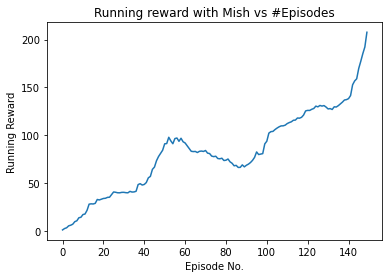

In [121]:
plt.plot(reward_plot)
plt.title('Running reward with Mish vs #Episodes')
plt.xlabel('Episode No.')
plt.ylabel('Running Reward')
plt.show()

# Test If Trained Model 'Solves' CartPole 

According to the OpenAI wiki, CartPole-v0 is solved if average score across 100 consecutive trials is equal to 195.0

In [177]:
seed = np.random.randint(0, 100)
while (seed == 42): #make sure seed is different from training
    seed = np.random.randint(0, 100)
print('seed found: {}'.format(seed))
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003

env = gym.make('CartPole-v1')
env.seed(seed)

#common layers
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.Dense(n_hidden)(l2)
common = tfa.activations.mish(l3)

#create actor and critic model
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.Huber()


model.load_weights(filename_cart)

score = []
trials = []
for _ in range(100):
    state = env.reset()
    trial_reward = 0

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_prob, _ = model(state)
    action = np.random.choice(n_actions, p = np.squeeze(action_prob))

    state, reward, done, info = env.step(action)
    trial_reward += reward
    # a solved Cart problem is avg score > 195 over 100 trials
    while trial_reward < 250: #setting cap on reward for run time
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)

        action_prob, _ = model(state)
        action = np.random.choice(n_actions, p = np.squeeze(action_prob))

        state, reward, done, info = env.step(action)
        trial_reward += reward
        if done: #if model fails in episode, break loop and start new trial, add whatever reward to trials
            break
    trials.append(trial_reward)

print('Average reward over 100 trials: {}'.format(sum(trials)/100))
if sum(trials)/100 > 195:
    print('Average trial score is over 195, problem is solved.')

seed found: 43
Average reward over 100 trials: 250.0
Average trial score is over 195, problem is solved.


**(Screenshot) Trained weights successfully balancing pole**:

Trained weights run in different file with `env.render()` set to true and `time.sleep(1/60)` to be easily watched
![res.png](res.png)

# Make sure equivalet ReLU algorithm can solve CartPole

Before we compare the algorithms, we must make sure the same function's trained model can solve the problem. For this algorithm, hyperparameter tuning yielded the same results, settling on a learning rate of 3e-3 and hidden val of 128. The same range of hyperparamters were tested with this model

In [5]:
seed = 42
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003
gamma = 0.99
MAX_STEPS = 10000 #max steps per episode
eps = np.finfo(np.float32).eps.item()
states, action_prob_grads, rewards, action_probs = [], [], [], []
reward_sum = 0
episode_number = 0

#common layers
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden, activation = 'relu')(inputs)
common = layers.Dense(n_hidden, activation = 'relu')(l1)

#create actor and critic model
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model = keras.Model(inputs=inputs, outputs=[action, critic])
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.Huber()

action_probs_history = []
critic_value_history = []
rewards_history = []
episode_count = 0
running_reward = 0
reward_plot = []

env = gym.make('CartPole-v1')
env.seed(seed)

filename = 'weights_relu.h5'
while True:
    state = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        for step in range(1, MAX_STEPS):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = np.random.choice(n_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done: break

        #modified update running reward function from keras tutorial
        running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        reward_plot.append(running_reward)
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = np.array(returns)
        returns = (returns - np.mean(returns))/(np.std(returns)+eps)
        returns = returns.tolist()

        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            #update critic
            critic_losses.append(
                loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

        episode_count += 1
        if episode_count % 10 == 0:
            clear_output(wait=True)
            print('episode {}, reward {}'.format(episode_count, running_reward))
        if running_reward > 195:
            print("Solved at episode {}".format(episode_count))
            model.save_weights(filename)
            break
env.close()

env = gym.make('CartPole-v1')
seed = np.random.randint(0, 100)
while (seed == 42): #make sure seed is different from training
    seed = np.random.randint(0, 100)
print('Seed found. Seed is: {}'.format(seed))
env.seed(seed)

trials = []
for _ in range(100):
    trial_reward = 0
    state = env.reset()

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_prob, _ = model(state)
    action = np.random.choice(n_actions, p = np.squeeze(action_prob))

    state, reward, done, info = env.step(action)
    trial_reward += reward
    # a solved Cart problem is avg score > 195 over 100 trials
    while trial_reward < 250: #setting cap on reward for run time

        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)

        action_prob, _ = model(state)
        action = np.random.choice(n_actions, p = np.squeeze(action_prob))

        state, reward, done, info = env.step(action)
        trial_reward += reward
        if done:
            break
    trials.append(trial_reward)

print('Average reward over 100 trials: {}'.format(sum(trials)/100))
if sum(trials)/100 >195:
    print('Average trial score is over 195, problem is solved.')

episode 190, reward 166.43532173664954
Solved at episode 195
Seed found. Seed is: 60
Average reward over 100 trials: 229.61
Average trial score is over 195, problem is solved.


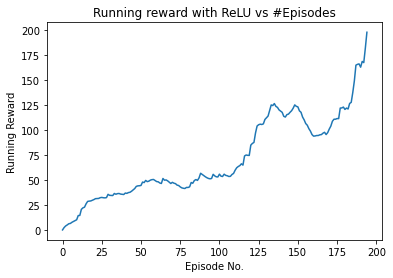

In [7]:
plt.plot(reward_plot)
plt.title('Running reward with ReLU vs #Episodes')
plt.xlabel('Episode No.')
plt.ylabel('Running Reward')
plt.show()

# Comparison of convergence between useage of ReLU and Mish

First, we will collect data from training the model above $100 [0 <= i <= 99]$ times from scratch. Both models will reinitialize the model weights and environment with `seed = 42` each trial

In [125]:
seed = 42
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003
gamma = 0.99
MAX_STEPS = 10000 #max steps per episode
eps = np.finfo(np.float32).eps.item()
states, action_prob_grads, rewards, action_probs = [], [], [], []
reward_sum = 0
episode_number = 0
best_episodes = 999
mish_convergence = []
filename_best_mish = 'best_mish_100_trials.h5'
env = gym.make('CartPole-v1')
env.seed(seed)
# for loop of above training code
for i in range(100):
    #initialize model
    #common layers
    env.reset()
    inputs = layers.Input(shape = (n_inputs, ))
    l1 = layers.Dense(n_hidden)(inputs)
    l2 = tfa.activations.mish(l1)
    l3 = layers.Dense(n_hidden)(l2)
    common = tfa.activations.mish(l3)

    #create actor and critic model
    action = layers.Dense(n_actions, activation = 'softmax')(common)
    critic = layers.Dense(1)(common)
    model = keras.Model(inputs=inputs, outputs=[action, critic])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.MeanSquaredError()

    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_count = 0
    running_reward = 0
    reward_plot = []
    
    
    while True:
        state = env.reset()
        episode_reward = 0

        with tf.GradientTape() as tape:
            for step in range(1, MAX_STEPS):
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0,0])

                action = np.random.choice(n_actions, p = np.squeeze(action_probs))
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done: break

            #modified update running reward function from keras tutorial
            running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
            reward_plot.append(running_reward)
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)

            returns = np.array(returns)
            returns = (returns - np.mean(returns))/(np.std(returns)+eps)
            returns = returns.tolist()

            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                diff = ret - value
                actor_losses.append(-log_prob * diff)
                #update critic
                critic_losses.append(
                    loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                )

            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()
            
            episode_count += 1
            if episode_count % 10 == 0:
                print('Trial{}, episode no. {}, reward {}'.format(i+1, episode_count, running_reward))
            if running_reward > 195:
                print("Trial {} Solved at episode {}".format(i+1, episode_count))
                mish_convergence.append(episode_count)
                if (episode_count < best_episodes):
                    model.save_weights(filename_best_mish)
                break
    clear_output(wait=True)
    print('Progress update, trial no. {}'.format(i + 1))

Progress update, trial no. 100


The same algorithm is trained 100 times from scratch, but the Mish activation function is replaced by ReLU

In [133]:
seed = 42
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003
gamma = 0.99
MAX_STEPS = 10000 #max steps per episode
eps = np.finfo(np.float32).eps.item()
states, action_prob_grads, rewards, action_probs = [], [], [], []
reward_sum = 0
episode_number = 0
filename_best_relu = 'best_relu_100_trials.h5'
relu_convergence = []
# for loop of above training code
for i in range(100):
    #common layers
    inputs = layers.Input(shape = (n_inputs, ))
    l1 = layers.Dense(n_hidden, activation = 'relu')(inputs)
    common = layers.Dense(n_hidden, activation = 'relu')(l1)

    #create actor and critic model
    action = layers.Dense(n_actions, activation = 'softmax')(common)
    critic = layers.Dense(1)(common)
    model = keras.Model(inputs=inputs, outputs=[action, critic])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.Huber()

    action_probs_history = []
    critic_value_history = []
    rewards_history = []
    episode_count = 0
    running_reward = 0
    reward_plot = []
    
    env = gym.make('CartPole-v1')
    env.seed(seed)
    while True:
        state = env.reset()
        episode_reward = 0

        with tf.GradientTape() as tape:
            for step in range(1, MAX_STEPS):
                state = tf.convert_to_tensor(state)
                state = tf.expand_dims(state, 0)

                action_probs, critic_value = model(state)
                critic_value_history.append(critic_value[0,0])

                action = np.random.choice(n_actions, p = np.squeeze(action_probs))
                action_probs_history.append(tf.math.log(action_probs[0, action]))

                state, reward, done, _ = env.step(action)
                rewards_history.append(reward)
                episode_reward += reward

                if done: break

            #modified update running reward function from keras tutorial
            running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
            reward_plot.append(running_reward)
            returns = []
            discounted_sum = 0
            for r in rewards_history[::-1]:
                discounted_sum = r + gamma * discounted_sum
                returns.insert(0, discounted_sum)

            returns = np.array(returns)
            returns = (returns - np.mean(returns))/(np.std(returns)+eps)
            returns = returns.tolist()

            history = zip(action_probs_history, critic_value_history, returns)
            actor_losses = []
            critic_losses = []
            for log_prob, value, ret in history:
                diff = ret - value
                actor_losses.append(-log_prob * diff)
                #update critic
                critic_losses.append(
                    loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
                )

            loss_value = sum(actor_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            action_probs_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

            episode_count += 1
            if episode_count % 10 == 0:
                print('Trial{}, episode no. {}, reward {}'.format(i+1, episode_count, running_reward))
            if running_reward > 195:
                print("Trial {} Solved at episode {}".format(i+1, episode_count))
                relu_convergence.append(episode_count)
                if (episode_count < best_episodes):
                    model.save_weights(filename_best_relu)
                break
    clear_output(wait=True)
    env.close()
    print('Progress update, trial no. {}'.format(i + 1))

Progress update, trial no. 100


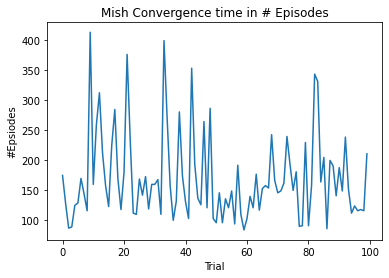

In [127]:
plt.plot(mish_convergence)
plt.title('Mish Convergence time in # Episodes')
plt.xlabel('Trial')
plt.ylabel('#Epsiodes')
plt.show()

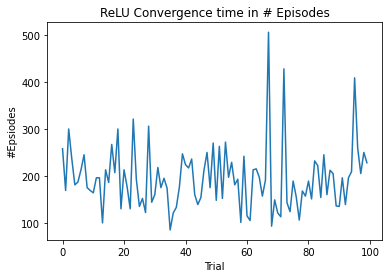

In [134]:
plt.plot(relu_convergence)
plt.title('ReLU Convergence time in # Episodes')
plt.xlabel('Trial')
plt.ylabel('#Epsiodes')
plt.show()

Text(0, 0.5, 'Frequency [#trials]')

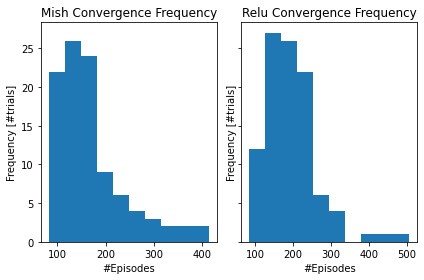

In [166]:
fig, axs = plt.subplots(1, 2, sharey = True, tight_layout=True)
n_bins = 10 #n_bins = sqrt(num trials = 100)
axs[0].hist(mish_convergence, bins=n_bins)
axs[0].set_title('Mish Convergence Frequency')
axs[0].set_xlabel('#Episodes')
axs[0].set_ylabel('Frequency [#trials]')
axs[1].hist(relu_convergence, bins=n_bins)
axs[1].set_title('Relu Convergence Frequency')
axs[1].set_xlabel('#Episodes')
axs[1].set_ylabel('Frequency [#trials]')

In [138]:
avg_mish = sum(mish_convergence)/len(mish_convergence)
peak_mish = max(mish_convergence)
min_mish = min(mish_convergence)
avg_relu = sum(relu_convergence)/len(relu_convergence)
peak_relu = max(relu_convergence)
min_relu = min(relu_convergence)
# # see table in next cell
print('Mish results:')
print('Avg Convergence = {} episodes '.format(avg_mish))
print('Peak Convergence = {} episodes '.format(peak_mish))
print('Min Convergence = {} episodes '.format(min_mish))
print('ReLU results:')
print('Avg Convergence = {} episodes '.format(avg_relu))
print('Peak Convergence = {} episodes '.format(peak_relu))
print('Min Convergence = {} episodes '.format(min_relu))

Mish results:
Avg Convergence = 168.82 episodes 
Peak Convergence = 413 episodes 
Min Convergence = 83 episodes 
ReLU results:
Avg Convergence = 194.63 episodes 
Peak Convergence = 506 episodes 
Min Convergence = 85 episodes 


| Function | Avg Convergence | Fastest Convergence | Slowest Convergence | Standard Deviation |
| :---- | :---- | :---- | :---- | :---- | 
| Mish | 168.82 Eps | 83 Eps | 413 Eps | 71.99 Eps |
| ReLU | 194.63 Eps | 85 Eps | 506 Eps | 67.65 Eps |

In [139]:
print((avg_relu - avg_mish)/(avg_relu + avg_mish)*100) # percent difference in avg convergence
print((min_relu - min_mish)/(min_relu + min_mish)*100) # percent difference in min convergence
print((peak_relu - peak_mish)/(peak_relu + peak_mish)*100) # percent difference in peak convergence
print(np.std(mish_convergence))
print(np.std(relu_convergence))

7.101389462099326
1.1904761904761905
10.119695321001087
71.98949645608032
67.65259122901354


## Check if best trial for both Mish and  ReLU model 'solves' Cartpole-v1

In [182]:
n_actions = 2
n_inputs = 4
n_hidden = 128
lr = 0.003
#find seed for both tests
seed = np.random.randint(0, 100)
while (seed == 42): #make sure seed is different from training
    seed = np.random.randint(0, 100)
print('seed found: {}'.format(seed))
#Mish model
inputs = layers.Input(shape = (n_inputs, ))
l1 = layers.Dense(n_hidden)(inputs)
l2 = tfa.activations.mish(l1)
l3 = layers.Dense(n_hidden)(l2)
common_1 = tfa.activations.mish(l3)
action_1 = layers.Dense(n_actions, activation = 'softmax')(common_1)
critic_1 = layers.Dense(1)(common_1)
model_mish = keras.Model(inputs=inputs, outputs=[action_1, critic_1])
model_mish.load_weights(filename_best_mish)

#relu model
inputs_2 = layers.Input(shape = (n_inputs, ))
dense = layers.Dense(n_hidden, activation = 'relu')(inputs_2)
common = layers.Dense(n_hidden, activation = 'relu')(dense)
action = layers.Dense(n_actions, activation = 'softmax')(common)
critic = layers.Dense(1)(common)
model_relu = keras.Model(inputs=inputs_2, outputs=[action, critic])
model_relu.load_weights(filename_best_relu)

optimizer = keras.optimizers.Adam(learning_rate=lr)
loss = keras.losses.Huber()

for model in [model_mish, model_relu]:    
    if model == model_mish:
        print('testing fastest convergence mish weights')
    else:
        print('testing fastest convergence ReLU weights')
    
    env = gym.make('CartPole-v1')
    env.seed(seed)
    score = []
    trials = []
    for _ in range(100):

        state = env.reset()
        trial_reward = 0

        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)

        action_prob, _ = model(state)
        action = np.random.choice(n_actions, p = np.squeeze(action_prob))

        state, reward, done, info = env.step(action)
        trial_reward += reward
        # a solved Cart problem is avg score > 195 over 100 trials
        while trial_reward < 250: #setting cap on reward for run time
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            action_prob, _ = model(state)
            action = np.random.choice(n_actions, p = np.squeeze(action_prob))

            state, reward, done, info = env.step(action)
            trial_reward += reward
            if done: #if model fails in episode, break loop and start new trial, add whatever reward to trials
                break
        trials.append(trial_reward)

    print('Average reward over 100 trials: {}'.format(sum(trials)/100))
    if sum(trials)/100 > 195:
        print('Average trial score is over 195, problem is solved.')

seed found: 51
testing fastest convergence mish weights
Average reward over 100 trials: 247.13
Average trial score is over 195, problem is solved.
testing fastest convergence ReLU weights
Average reward over 100 trials: 246.62
Average trial score is over 195, problem is solved.


In our experiment of 100 trials, Mish performs ~7.1% better than ReLU in average convergence episode. Mish has a ~1.2% lower fastest individual convergence trial than ReLU. ReLU algorithm also had a ~10.12% slower worst trial than the Mish algorithm

Both models were tested with optimized hyperparamters. A clear improvement can be observed when comparing the results. However looking at the charts, it is worthy to note that the ReLU model had a slightly tighter grouping, which is backed up by its standard deviation being ~3 episodes lower than the Mish model. I do not believe this to be significant enough evidence that ReLU is a more reliable activation function for reinforcement learning. Also on testing for the solve condition [100 trials > 195 reward], I gave an extended cap per trial of 250 reward but found no discernable difference between the two models final weights. This makes mish a clear benefit in the specific realm of convergence rate, but not final accuracy

For future work, I would like to make this comparison on different types of reinforcement models. I would also like to run this experiment with different learning problems given more time.

### Computer Specifications
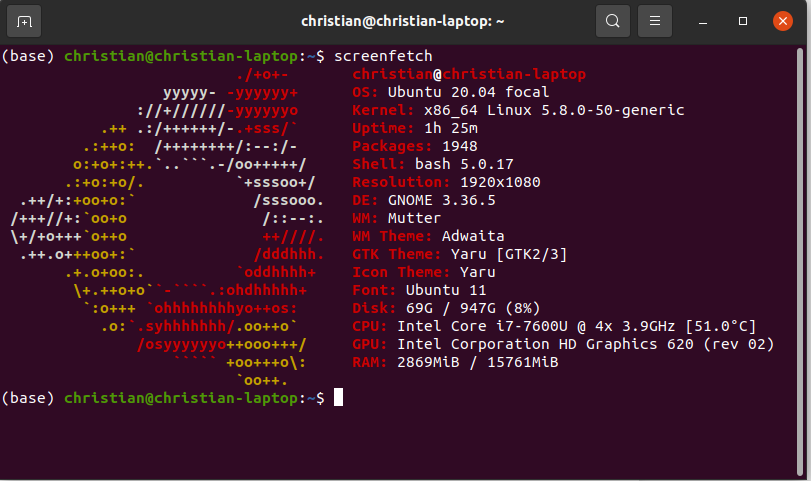